# Downloading data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tickers = ["SAF.PA", "ATO.PA", "MC.PA", "AIR.PA", "RNO.PA", "HO.PA", "ENGI.PA", "CS.PA", "ENR.DE", "TOT", "CA.PA", "SU.PA", "BN.PA", "SIEGY", "AI.PA", "ML.PA", "AM.PA", "ORA.PA",  "FR0007052782.SG"]
period = "2y"

In [3]:
ohlc = yf.download(tickers, period=period)
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AIR.PA,ATO.PA,CS.PA,ENGI.PA,ENR.DE,HO.PA,MC.PA,RNO.PA,SAF.PA,TOT
Date,,,,,,,,,,
2020-12-28,91.980003,75.300003,19.728001,12.900,29.730000,75.680000,504.000000,36.110001,119.949997,42.413864
2020-12-29,93.070000,75.760002,19.736000,12.755,29.900000,76.320000,512.799988,36.255001,120.500000,42.512001
2020-12-30,91.250000,75.339996,19.676001,12.695,30.000000,75.440002,513.099976,35.945000,119.000000,42.669998
2020-12-31,89.779999,74.779999,19.511999,12.520,NaN,74.900002,510.899994,35.759998,115.949997,41.910000
2021-01-04,89.889999,76.120003,19.438000,12.805,30.129999,75.180000,512.099976,35.759998,116.150002,42.380001


In [4]:
market_prices = yf.download("^FCHI", period=period)["Adj Close"]
market_prices.head()


[*********************100%***********************]  1 of 1 completed


Date
2019-01-04    4737.120117
2019-01-07    4719.169922
2019-01-08    4773.270020
2019-01-09    4813.580078
2019-01-10    4805.660156
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tqdm(tickers):
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.52s/it]


In [6]:
mcaps

{'SAF.PA': 49588846592,
 'ATO.PA': 8368633344,
 'MC.PA': 258050244608,
 'AIR.PA': 70448144384,
 'RNO.PA': 10383272960,
 'HO.PA': 16002814976,
 'ENGI.PA': 30947381248,
 'CS.PA': 46335721472,
 'ENR.DE': 12153989120,
 'TOT': 115413041152}

# Constructing the prior¶


In [7]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.5192887221015647

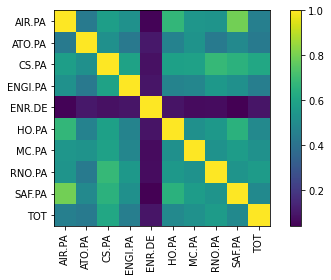

In [8]:
plotting.plot_covariance(S, plot_correlation=True);


In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AIR.PA     0.211797
ATO.PA     0.119274
CS.PA      0.144824
ENGI.PA    0.117140
ENR.DE     0.027215
HO.PA      0.137631
MC.PA      0.142924
RNO.PA     0.198142
SAF.PA     0.208159
TOT        0.165501
dtype: float64

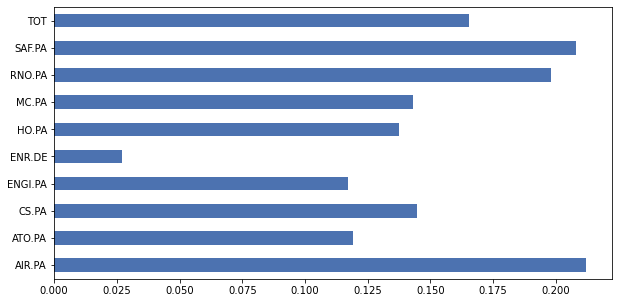

In [10]:
market_prior.plot.barh(figsize=(10,5));


# Views

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "SAF.PA":-0.01, 
    "ATO.PA":0.15, 
    "MC.PA":-0.06, 
    "AIR.PA":0.06, 
    "RNO.PA":-0.12, 
    "HO.PA":0.12, 
    "ENGI.PA" : 0.16, 
    "TOT" : 0.17,
    "ENR.DE":-0.027,
    "CS.PA":0.22,
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

## View confidences


In [12]:
confidences = [
    0.7,#SAFRAN
    0.7,#ATOS
    0.3,#LVMH
    0.6,#AIRBUS
    0.3,#RNO
    0.6,#Thales
    0.3,#ENGIE
    0.3,#TOTAL
    0.3,#SIEMENS ENERGY
    0.3 #AXA
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)


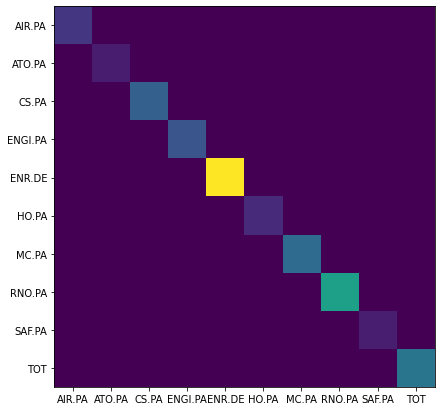

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)


array([0.00565163, 0.00271865, 0.01110963, 0.00951223, 0.03600991,
       0.00438299, 0.01260052, 0.0203283 , 0.00301438, 0.0140658 ])

In [16]:
def stockreturn(prices, ticker, shift=1):
    stock_returns = (prices[ticker] / prices[ticker] .shift(shift)) - 1
    stock_returns =  stock_returns.to_frame()
    stock_returns.columns = [f'{ticker} {shift} days Return']
    return stock_returns




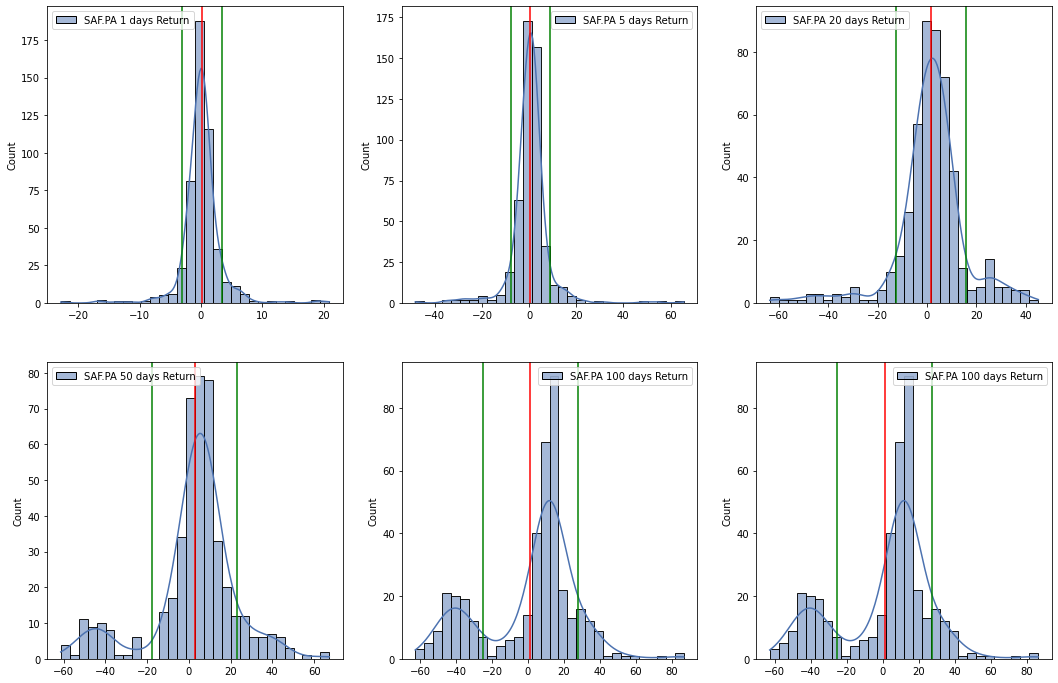

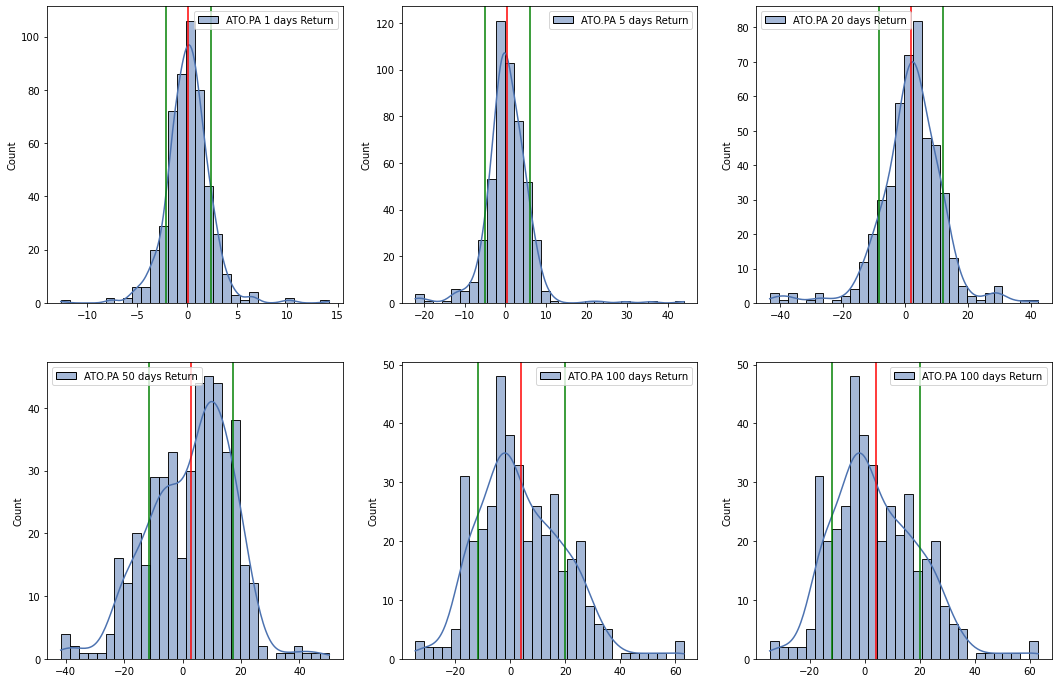

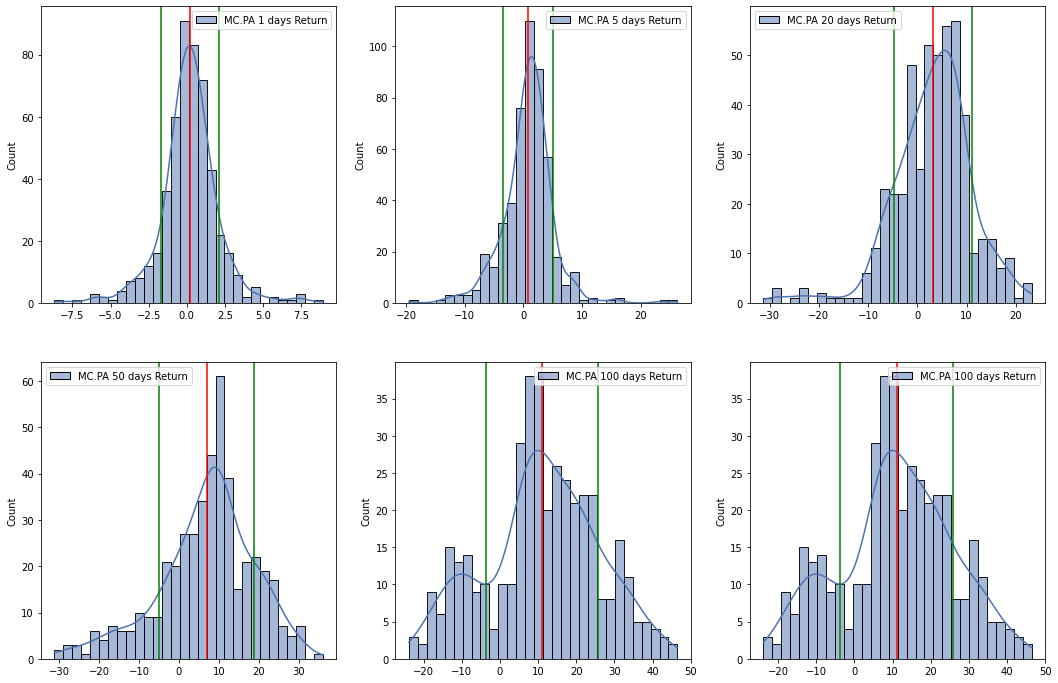

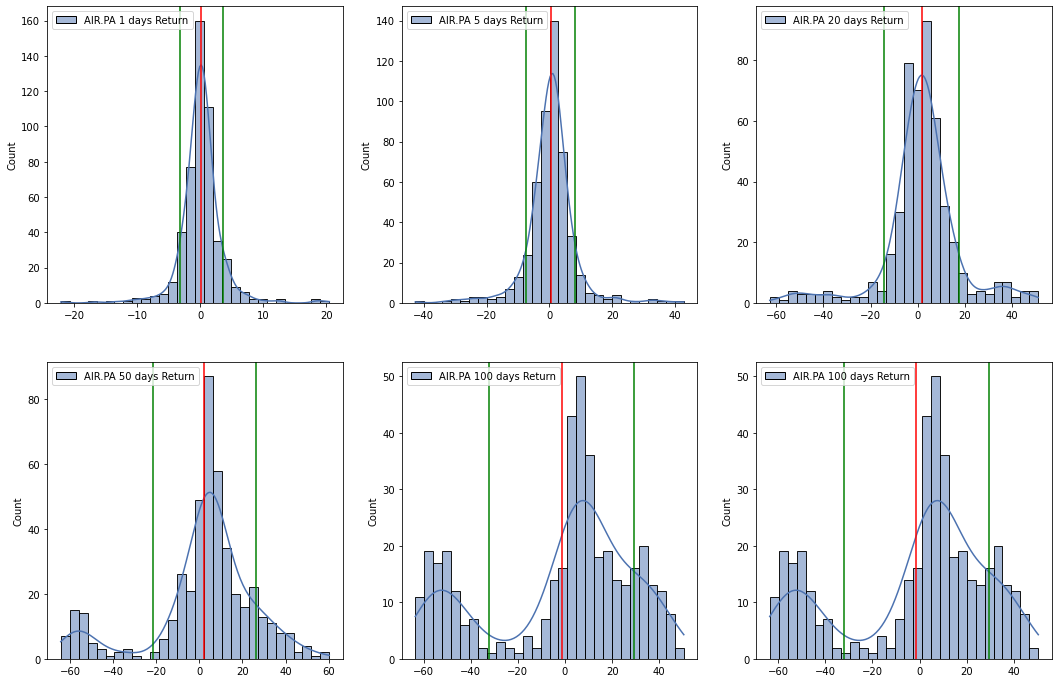

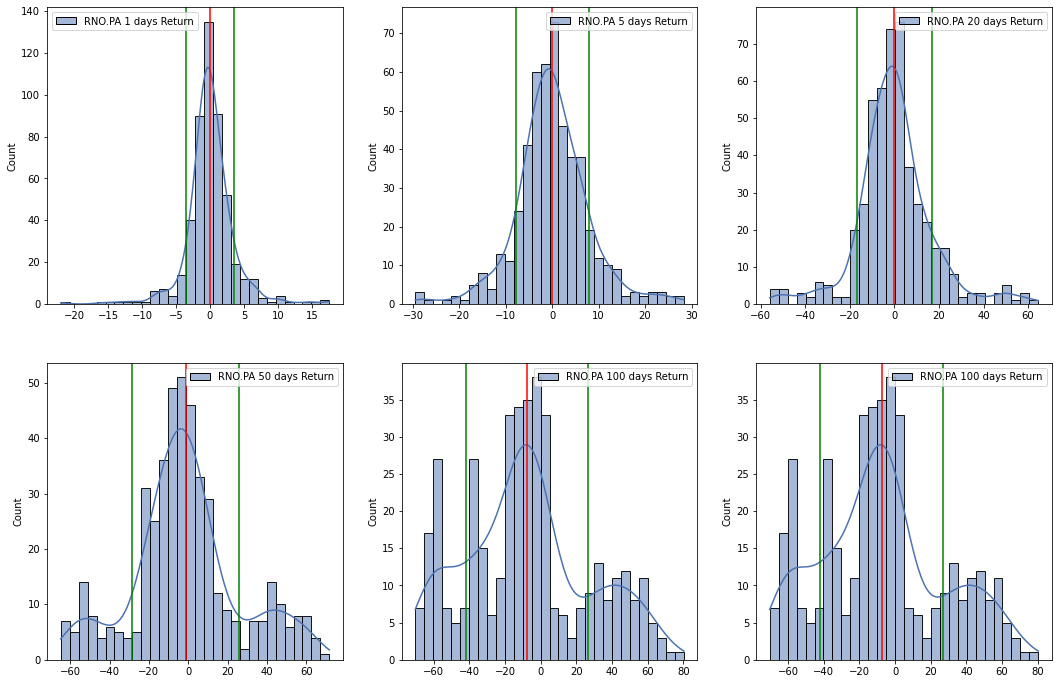

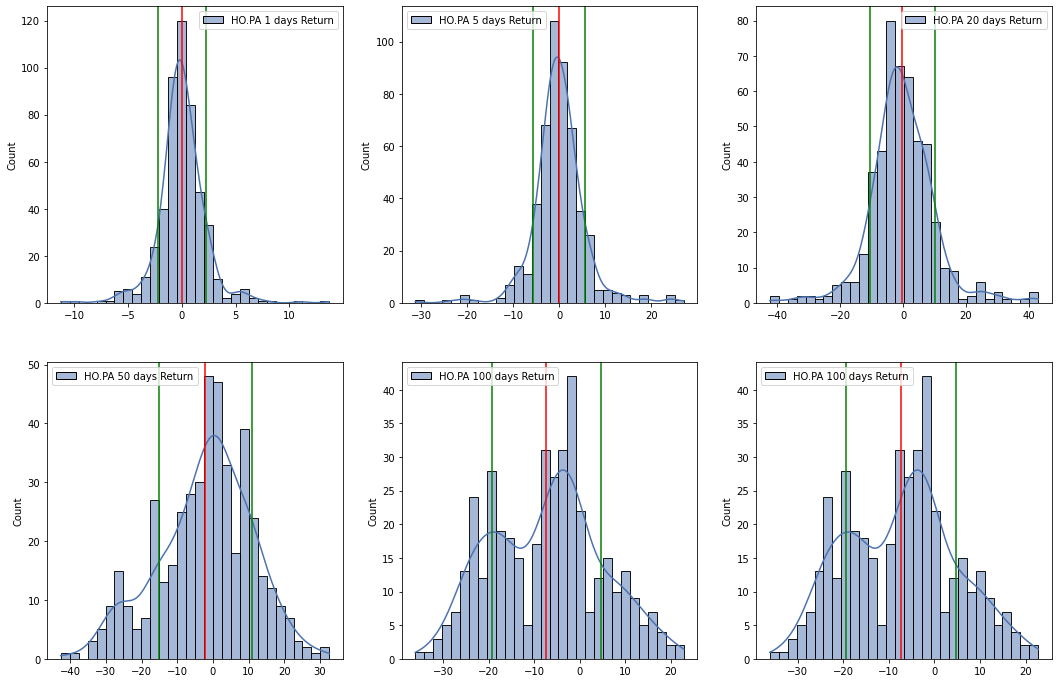

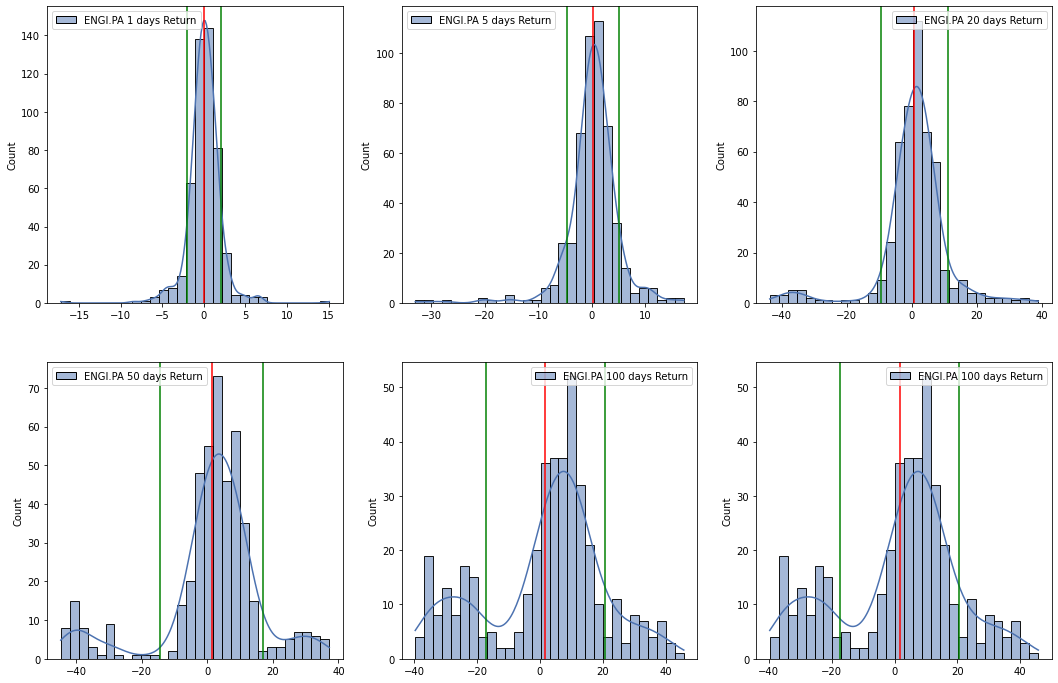

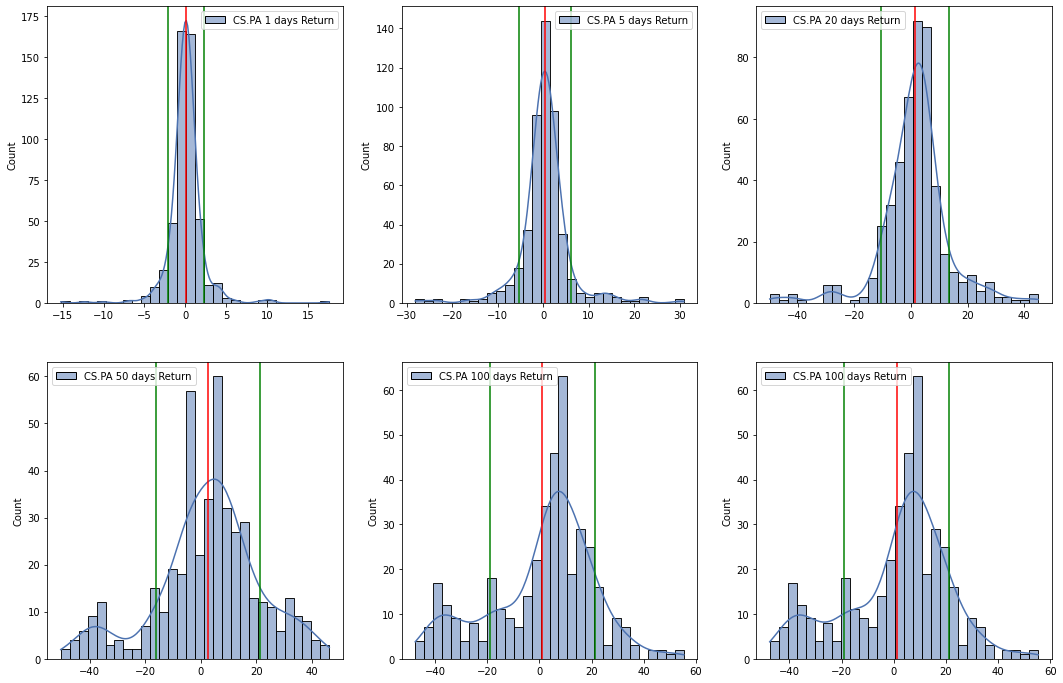

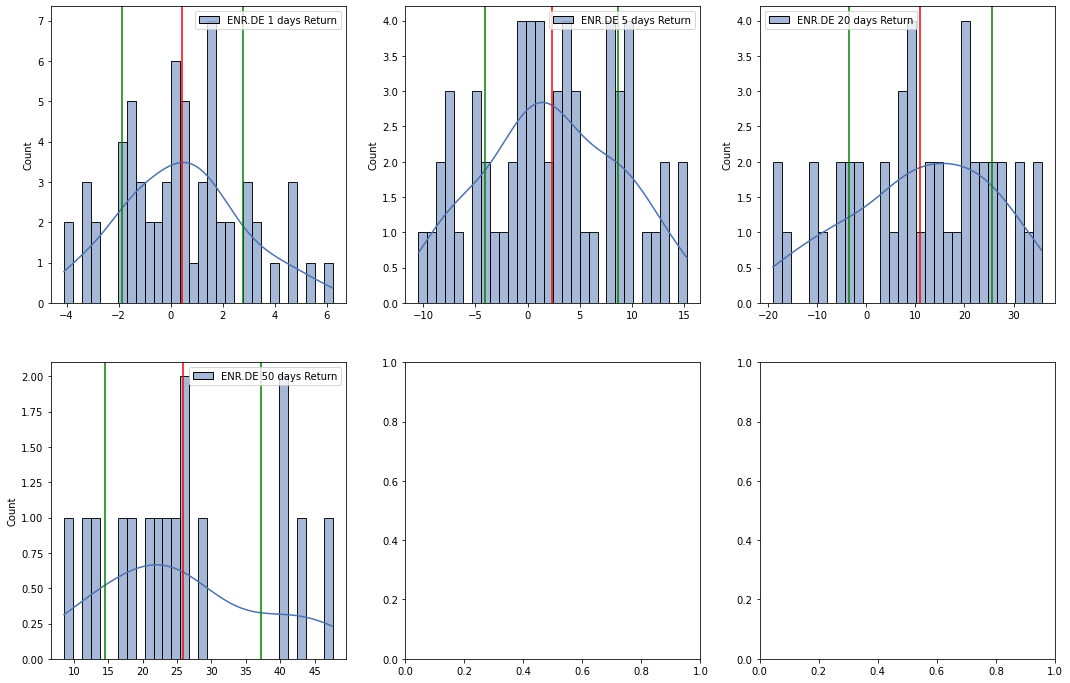

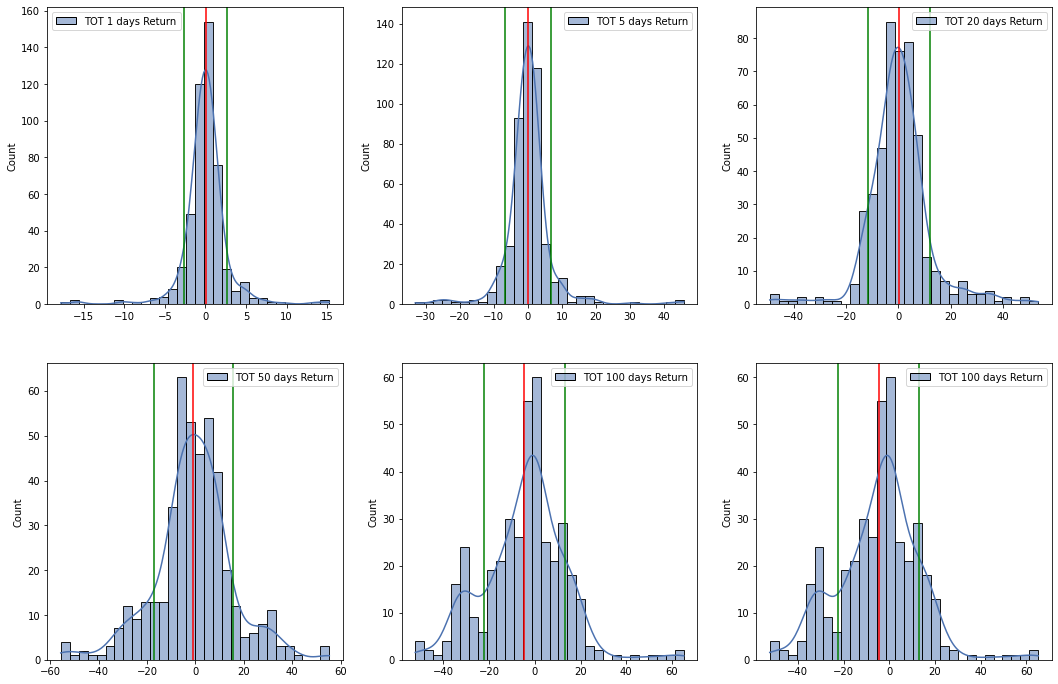

In [17]:
for t in tickers:
    fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*6))
    for ax, shift in zip(axs.flat, [1, 5, 20, 50, 100, 100]):
        try:
            x = stockreturn(prices, t, shift=shift)*100
            sns.histplot(x, kde=True, ax = ax, bins=30) #binwidth=10)
            ax.axvline(np.nanmean(x.values), color="red")
            ax.axvline(np.nanmean(x.values) - np.nanstd(x.values), color="green")
            ax.axvline(np.nanmean(x.values) + np.nanstd(x.values), color="green")
        except ValueError:
            pass
    plt.show()

In [18]:
intervals = [
    (-0.2, 0.4),#SAFRAN
    (-0.12, 0.2),#ATOS
    (0, 0.25),#LVMH
    (-0.35, 0.4),#AIRBUS
    (-0.2, 0.5),#RNO
    (-0.2, 0.1),#Thales
    (-0.15, 0.25),#ENGIE
    (-0.2, 0.2),#TOTAL
    (0.15, 0.35),#SIEMENS ENERGY
    (-0.2, 0.25),#AXA
]

In [19]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.09000000000000002, 0.0256, 0.015625, 0.140625, 0.12249999999999998, 0.022500000000000006, 0.04000000000000001, 0.04000000000000001, 0.009999999999999998, 0.050625]


## Posterior estimates

In [20]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [21]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AIR.PA     0.149275
ATO.PA     0.086625
CS.PA      0.104912
ENGI.PA    0.083524
ENR.DE     0.003080
HO.PA      0.096096
MC.PA      0.084373
RNO.PA     0.133569
SAF.PA     0.145659
TOT        0.125082
dtype: float64

In [22]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AIR.PA,0.211797,0.149275,0.060
ATO.PA,0.119274,0.086625,0.150
CS.PA,0.144824,0.104912,0.220
ENGI.PA,0.117140,0.083524,0.160
ENR.DE,0.027215,0.003080,-0.027
HO.PA,0.137631,0.096096,0.120
MC.PA,0.142924,0.084373,-0.060
RNO.PA,0.198142,0.133569,-0.120
SAF.PA,0.208159,0.145659,-0.010
TOT,0.165501,0.125082,0.170


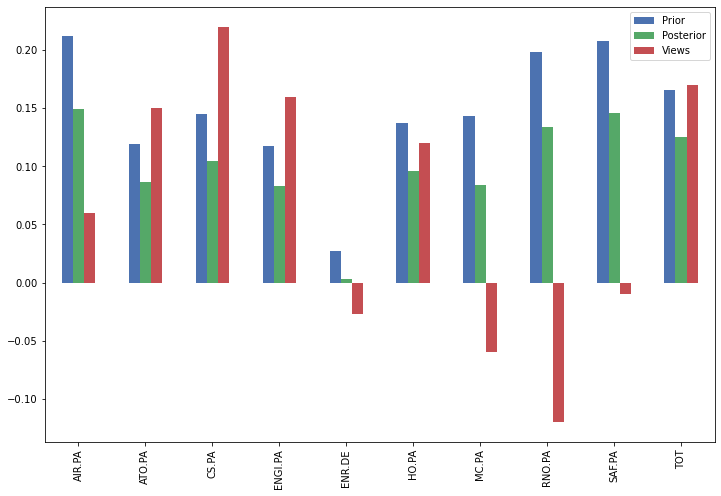

In [23]:
rets_df.plot.bar(figsize=(12,8));


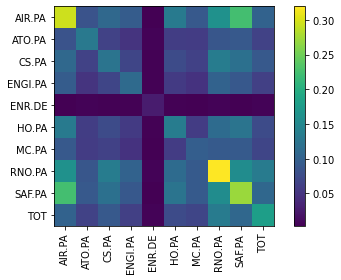

In [24]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio allocation

In [25]:
from pypfopt import EfficientFrontier, objective_functions


In [26]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\D580656\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AIR.PA', 0.15455),
             ('ATO.PA', 0.08261),
             ('CS.PA', 0.10543),
             ('ENGI.PA', 0.07509),
             ('ENR.DE', 0.0),
             ('HO.PA', 0.08634),
             ('MC.PA', 0.07821),
             ('RNO.PA', 0.12137),
             ('SAF.PA', 0.14893),
             ('TOT', 0.14747)])

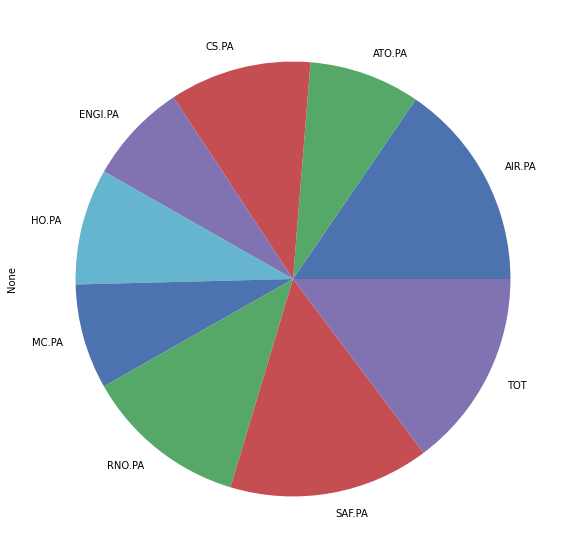

In [31]:
pd.Series(weights).plot.pie(figsize=(10,10));


In [33]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=1200)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $10.37


{'AIR.PA': 2,
 'ATO.PA': 1,
 'CS.PA': 7,
 'ENGI.PA': 8,
 'HO.PA': 2,
 'RNO.PA': 4,
 'SAF.PA': 2,
 'TOT': 4}